![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Decoupling: Sorting bins method
</b>
</span>

---
**Notebook version**: `1` (19 Mar 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)

</br>

# **Description**

- Calculate daily correlation between two time series.


</br>

# **Imports**

In [1]:
import importlib.metadata
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")
from diive.pkgs.analyses.decoupling import SortingBinsMethod
from diive.configs.exampledata import load_exampledata_parquet  # Example data

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.83.2


</br>

# **Load example data**

In [2]:
vpd_col = 'VPD_f'  # Vapor pressure deficit
ta_col = 'Tair_f'  # Air temperature
swin_col = 'Rg_f'  # Radiation used to detect daytime data

In [3]:
# Load 10-year dataset of half-hourly measurements
df = load_exampledata_parquet()

# Keep data between June and September
df = df.loc[(df.index.month >= 6) & (df.index.month <= 9)].copy()

# Keep daytime data (radiation > 50 W m-2) and data when air temperatures was > 5°C
daytime_locs = (df[swin_col] > 50) & (df[ta_col] > 0)
df = df[daytime_locs].copy()

# Rename variables
rename_dict = {
    ta_col: 'air_temperature',
    vpd_col: 'vapor_pressure_deficit',
    swin_col: 'short-wave_incoming_radiation'
}
df = df.rename(columns=rename_dict, inplace=False)

# Use new column names
ta_col = 'air_temperature'
vpd_col = 'vapor_pressure_deficit'
swin_col = 'short-wave_incoming_radiation'

# Make subset
df = df[[ta_col, vpd_col, swin_col]].copy()

df

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.051 seconds). Detected time resolution of <30 * Minutes> / 30min 


,air_temperature,vapor_pressure_deficit,short-wave_incoming_radiation
TIMESTAMP_MIDDLE,,,
2013-06-01 06:45:00,0.233,0.062,108.790
2013-06-01 07:15:00,0.333,0.065,137.107
2013-06-01 07:45:00,0.400,0.000,172.567
2013-06-01 08:15:00,1.000,0.066,250.213
2013-06-01 08:45:00,1.433,0.097,249.253
...,...,...,...
2022-09-30 15:15:00,3.293,0.000,85.808
2022-09-30 15:45:00,3.033,0.006,117.456
2022-09-30 16:15:00,3.217,0.156,111.235


</br>

# **Calculate bin medians**

In [4]:
sbm = SortingBinsMethod(df=df,
                        var1_col=ta_col,
                        var2_col=swin_col,
                        var3_col=vpd_col,
                        n_bins_var1=5,
                        n_subbins_var2=10,
                        convert_to_percentiles=False)
sbm.calcbins()

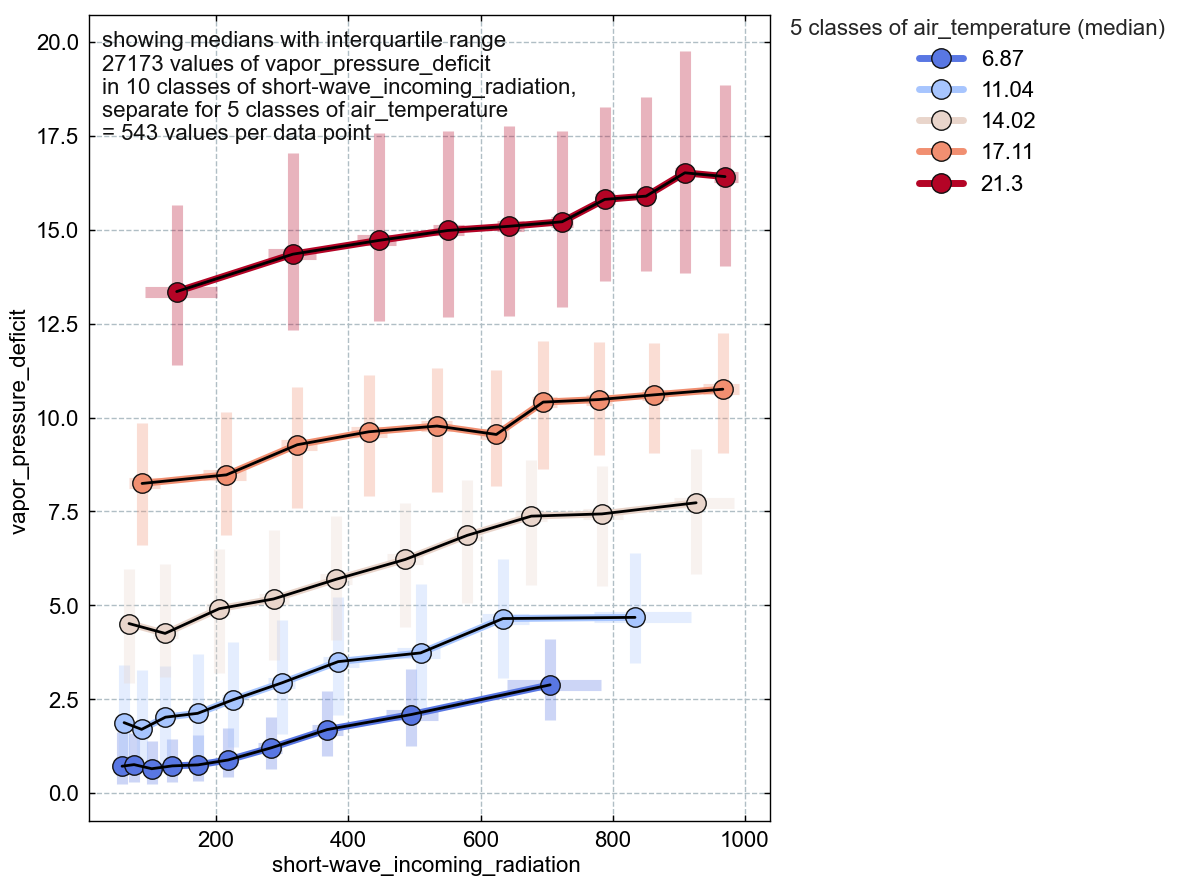

In [5]:
sbm.showplot_decoupling_sbm(marker='o', emphasize_lines=True)

Binning results (were also used to create the plot):

In [6]:
binmedians = sbm.get_binmedians()

In this example, the air temperature median is used as key in the results dictionary:

In [7]:
keys = []
for group_key, group_df in binmedians.items():
    keys.append(group_key)
print(keys, end=" ")

['6.87', '11.04', '14.02', '17.11', '21.3'] 

To access the results for the warmest class:

In [8]:
binmedians['21.3']

,group_short-wave_incoming_radiation,air_temperature,vapor_pressure_deficit,short-wave_incoming_radiation,short-wave_incoming_radiation_P25,vapor_pressure_deficit_P25,short-wave_incoming_radiation_P75,vapor_pressure_deficit_P75,xerror_neg,xerror_pos,yerror_neg,yerror_pos
0,"(50.501000000000005, 248.858]",20.4330,13.3525,140.008,92.02800,11.40375,201.57950,15.65250,47.98000,61.57150,1.94875,2.30000
1,"(248.858, 378.989]",20.6960,14.3480,315.860,278.93300,12.33350,350.21200,17.04200,36.92700,34.35200,2.01450,2.69400
2,"(378.989, 500.326]",20.6470,14.7150,446.342,413.71000,12.57100,472.44800,17.56800,32.63200,26.10600,2.14400,2.85300
3,"(500.326, 601.225]",20.8415,14.9785,550.305,528.49100,12.67200,575.12000,17.61575,21.81400,24.81500,2.30650,2.63725
4,"(601.225, 689.158]",20.8230,15.0900,642.814,624.39800,12.69400,666.48450,17.76000,18.41600,23.67050,2.39600,2.67000
5,"(689.158, 757.765]",20.7400,15.2110,723.487,706.05950,12.94750,739.49750,17.62350,17.42750,16.01050,2.26350,2.41250
6,"(757.765, 819.964]",20.9990,15.8060,788.087,772.60125,13.62625,803.77825,18.25525,15.48575,15.69125,2.17975,2.44925
7,"(819.964, 880.475]",21.2130,15.8940,850.640,835.75400,13.89300,863.29500,18.52250,14.88600,12.65500,2.00100,2.62850
8,"(880.475, 937.218]",21.4670,16.5140,909.293,894.87000,13.85050,923.40050,19.74600,14.42300,14.10750,2.66350,3.23200
9,"(937.218, 1113.006]",21.1315,16.4130,970.088,952.95125,14.02300,989.82150,18.84325,17.13675,19.73350,2.39000,2.43025


</br>

# **End of notebook**

In [9]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2024-10-24 13:39:04
